## 🌀 Diffusion DDPM with Contextual U-Net

 Welcome to this notebook on **Denoising Diffusion Probabilistic Models (DDPM)**. 
This guide will help you understand the structure and training of a diffusion model conditioned on context,
applied here to a visual dataset like CLEVR.

### 🧠 What you'll learn:
 - The principles behind DDPMs
 - How noise is added and removed from data over time
 - How a Contextual U-Net can condition image generation
 - The training pipeline and how to sample new data


In [1]:
# Imports and Device Setup
import os
import json
import glob
import random
import math 
from tqdm import tqdm

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from argparse import Namespace
from einops import rearrange, pack, unpack

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

from paths import CV_PATH_DDPM

print(CV_PATH_DDPM)

Using device: cpu
data/image_gen


# Parameters (Override as needed for interactive runs)
These parameters define the behavior of training, model architecture, dataset, and sampling process.
You can adjust them as needed to control the model’s performance.

| Parameter | Description |
|----------|-------------|
| `lrate` | Learning rate |
| `test_size` | Size of the object in the test dataset |
| `num_samples` | Total number of samples |
| `batch_size` | Number of images per training batch |
| `n_T` | Number of diffusion steps |
| `n_feat` | Feature size in U-Net |
| `n_sample` | Number of samples during evaluation |
| `n_epoch` | Number of training epochs |
| `dataset` | Dataset name (e.g. CLEVR) |
| `pixel_size` | Size of image (e.g. 28x28 pixels) |

In [2]:
# Using Namespace to emulate argparse arguments
args = Namespace(
    lrate=1e-4,
    test_size=1.6,
    num_samples=5000,
    batch_size=64,
    n_T=500,
    n_feat=256,
    n_sample=64,
    n_epoch=100,
    type_attention="",
    pixel_size=28,
    dataset="clevr",
    seed=1,
    save_model_path='comp_model.pth',
    load_model_path=None
)

# Helper Functions and Schedules

## 📐 Diffusion Schedules

The schedules define how noise is added to the data during the forward process.
The reverse process attempts to recover clean data step-by-step.
### 📊 Key Variables
- **`beta_t`**: Variance schedule controlling noise at each timestep
- **`alpha_t`**: Data retention factor
- **`alphabar_t`**: Cumulative product of `alpha_t`
- **`sqrtab`, `sqrtmab`**: Precomputed factors used in forward/reverse diffusion

This section also includes helper functions like:
- `l2norm`: Normalize vectors using L2 norm
- `exists`: Simple None check


In [3]:
def l2norm(t):
    return F.normalize(t, dim=-1)

def exists(val):
    return val is not None

# DDPM Schedules
def ddpm_schedules(beta1, beta2, T):
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab = (1 - alpha_t) / sqrtmab
    return {
        'alpha_t': alpha_t,
        'oneover_sqrta': oneover_sqrta,
        'sqrt_beta_t': sqrt_beta_t,
        'alphabar_t': alphabar_t,
        'sqrtab': sqrtab,
        'sqrtmab': sqrtmab,
        'mab_over_sqrtmab': mab_over_sqrtmab,
    }

## 🧱 Model Components
We now build the architecture of the DDPM using the following modules:
### 🔁 Residual Blocks
Help preserve information across layers and stabilize training.

### 🔍 Attention Layers
Add the ability to focus on spatial regions of interest. Optional, but helpful in U-Net-based models.

### 🧩 U-Net Architecture
A U-Net is used to predict the noise at each step of the reverse diffusion process.
It consists of:
- Downsampling path
- Bottleneck
- Upsampling path with skip connections
- Embedding for conditioning on context/concepts

In [4]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        TODO:
        Implement a standard ResNet-style convolutional block.

        Args:
            in_channels (int): Number of channels in the input feature map.
            out_channels (int): Number of channels produced by the block (also number of channels after 1st Conv2D layer).
            is_res (bool): Whether to include a residual connection.

        - Use two Conv2D layers with:
            - kernel size = 3
            - stride = 1
            - padding = 1
        - Each followed by BatchNorm and GELU activation.
        - Track if in_channels == out_channels (used for skip connection logic).
        '''
        
        self.same_channels = in_channels == out_channels
        self.is_res = is_res

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

        #raise NotImplementedError("Define conv1, conv2, same_channels, and is_res here")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class RearrangeToSequence(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        x = rearrange(x, 'b c ... -> b ... c')
        x, ps = pack([x], 'b * c')

        x = self.fn(x)

        x, = unpack(x, ps, 'b * c')
        x = rearrange(x, 'b ... c -> b c ...')
        return x

class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5, fp16_eps = 1e-3, stable = False):
        super().__init__()
        self.eps = eps
        self.fp16_eps = fp16_eps
        self.stable = stable
        self.g = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        eps = self.eps if x.dtype == torch.float32 else self.fp16_eps

        if self.stable:
            x = x / x.amax(dim = -1, keepdim = True).detach()

        var = torch.var(x, dim = -1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = -1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

        
class Attention(nn.Module):
    '''General implementation of Cross & Self Attention multi-head
    '''
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=8, ):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.to_q = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            # Self Attention
            self.to_k = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.to_v = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.self_attn = True
        else:
            # Cross Attention
            self.to_k = nn.Linear(context_dim, embed_dim, bias=False)
            self.to_v = nn.Linear(context_dim, embed_dim, bias=False)
            self.self_attn = False
        self.to_out = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim, bias=True)
        )  # this could be omitted

    def forward(self, tokens, context=None):
        Q = self.to_q(tokens)
        K = self.to_k(tokens) if self.self_attn else self.to_k(context)
        V = self.to_v(tokens) if self.self_attn else self.to_v(context)
        # print(Q.shape, K.shape, V.shape)
        # transform heads onto batch dimension
        Q = rearrange(Q, 'B T (H D) -> (B H) T D', H=self.num_heads, D=self.head_dim)
        K = rearrange(K, 'B T (H D) -> (B H) T D', H=self.num_heads, D=self.head_dim)
        V = rearrange(V, 'B T (H D) -> (B H) T D', H=self.num_heads, D=self.head_dim)
        # print(Q.shape, K.shape, V.shape)
        scoremats = torch.einsum("BTD,BSD->BTS", Q, K)
        attnmats = F.softmax(scoremats / math.sqrt(self.head_dim), dim=-1)
        # print(scoremats.shape, attnmats.shape, )
        ctx_vecs = torch.einsum("BTS,BSD->BTD", attnmats, V)
        # split the heads transform back to hidden.
        ctx_vecs = rearrange(ctx_vecs, '(B H) T D -> B T (H D)', H=self.num_heads, D=self.head_dim)
        # TODO: note this `to_out` is also a linear layer, could be in principle merged into the to_value layer.
        return self.to_out(ctx_vecs)


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels, type_attention):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        attention = nn.Identity()
        if type_attention=="self":
            create_self_attn = lambda dim: RearrangeToSequence(Residual(Attention(dim)))
            attention = create_self_attn(out_channels)
        self.model = nn.Sequential(*[ResidualConvBlock(in_channels, out_channels), attention, nn.MaxPool2d(2)])

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, type_attention):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        attention = nn.Identity()
        if type_attention=="self": 
            create_self_attn = lambda dim: RearrangeToSequence(Residual(Attention(dim)))
            attention = create_self_attn(out_channels)
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            attention, 
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        TODO:
        Implement a simple feedforward embedding network.

        Args:
            input_dim (int): Dimension of the input features.
            emb_dim (int): Desired dimension of the embedding.

        Design:
        - First layer: Linear from input_dim → emb_dim
        - Activation: GELU
        - Second layer: Linear from emb_dim → emb_dim

        Store the entire sequence in self.model using nn.Sequential.
        '''
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim)
        )
        #raise NotImplementedError("Define a small MLP for projecting input to embedding")

    def forward(self, x):
        '''
        TODO:
        Flatten the input (if needed), and apply the embedding network.
        - Pass it through self.model

        Returns:
            Embedded representation of shape [batch_size, emb_dim]
        '''
        x_in = x.view(-1, self.input_dim)
        x = x.view(-1, self.input_dim)  # Flatten
        return self.model(x)
        # raise NotImplementedError("Implement the forward pass for the EmbedFC module")


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=[2,3,1], type_attention=""):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_contexts = len(n_classes)
        self.n_feat = 2 * n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat, type_attention)
        self.down2 = UnetDown(n_feat, 2 * n_feat, type_attention)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)

        ### embedding shape
        self.n_out1 = 2*n_feat 
        self.n_out2 = n_feat

        self.contextembed1 = nn.ModuleList([EmbedFC(self.n_classes[iclass], self.n_out1) for iclass in range(len(self.n_classes))])
        self.contextembed2 = nn.ModuleList([EmbedFC(self.n_classes[iclass], self.n_out2) for iclass in range(len(self.n_classes))])

        n_conv = 7
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, n_conv, n_conv), 
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat, type_attention)
        self.up2 = UnetUp(2 * n_feat, n_feat, type_attention)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )
    
    def forward(self, x, c, t, context_mask=None):
        '''
        Forward pass of the ContextU-Net.
    
        Inputs:
            x: Noisy input image (B x C x H x W)
            c: List of context labels (e.g. color, shape, size)
            t: Timestep tensor
            context_mask: Optional mask to ignore parts of context
    
        Forward pass outline:
        1. Pass x through init_conv, down1, down2
        2. Compress features using to_vec
        3. Embed timestep t using timeembed1 and timeembed2
        4. Embed context c using contextembed1 and contextembed2 (see below)
        5. Perform conditional upsampling (see below)
        6. Output final image with skip connection from input x
        '''
        
        # x is (noisy) image, c is context label, t is timestep, 
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
    
        temb1 = self.timeembed1(t).view(-1, int(self.n_feat), 1, 1)
        temb2 = self.timeembed2(t).view(-1, int(self.n_feat/2), 1, 1)
    
        # embed context, time step
        cemb1 = 0
        cemb2 = 0
        for ic in range(len(self.n_classes)):
            tmpc = c[ic]
            if tmpc.dtype==torch.int64: 
                tmpc = nn.functional.one_hot(tmpc, num_classes=self.n_classes[ic]).type(torch.float)
            cemb1 += self.contextembed1[ic](tmpc).view(-1, int(self.n_out1/1.), 1, 1)
            cemb2 += self.contextembed2[ic](tmpc).view(-1, int(self.n_out2/1.), 1, 1)
    
        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## DDPM

In [5]:
class DDPM(nn.Module):
    def __init__(self, model, betas, n_T, device):
        super().__init__()
        self.model = model.to(device)
        self.n_T   = n_T                               # number of diffusion steps

        # register pre‑computed schedules as buffers
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.mse = nn.MSELoss()

    # ------------------------------------------------------------------
    # 🔧 training forward pass
    # ------------------------------------------------------------------
    def forward(self, x_0, c_list):
        """
        Learn to predict the true noise ε added to x_0.

        Steps
        -----
        1. Sample random timestep t ∈ {1 … T}.
        2. Add Gaussian noise to obtain x_t.
        3. Predict ε̂ with the model (x_t, c, t/T).
        4. Return MSE(ε̂, ε).
        """
        B       = x_0.size(0)
        device  = x_0.device

        # 1) random timestep per sample
        t = torch.randint(1, self.n_T, (B,), device=device)

        # 2) true noise
        eps = torch.randn_like(x_0)

        # 3) noisy image x_t = √ᾱ_t · x₀ + √(1-ᾱ_t) · ε
        sqrtab_t  = self.sqrtab[t].view(B, 1, 1, 1)
        sqrtmab_t = self.sqrtmab[t].view(B, 1, 1, 1)
        x_t = sqrtab_t * x_0 + sqrtmab_t * eps

        # 4) predict noise
        t_norm   = (t / self.n_T).unsqueeze(1)         # shape [B,1]
        eps_pred = self.model(x_t, c_list, t_norm)

        # 5) loss
        return self.mse(eps_pred, eps)

    # ------------------------------------------------------------------
    # 🌀 sampling (reverse process)
    # ------------------------------------------------------------------
    @torch.no_grad()
    def sample(self, n, c_list, size):
        """
        Reverse diffusion: start from x_T ~ N(0,I) and iteratively denoise.
        """
        device = next(self.parameters()).device
        C, H, W = size

        # initial noise x_T
        x = torch.randn(n, C, H, W, device=device)

        for t in range(self.n_T, 0, -1):
            t_batch = torch.full((n,), t, device=device, dtype=torch.long)
            t_norm  = (t_batch / self.n_T).unsqueeze(1)

            # predict ε_t
            eps_t = self.model(x, c_list, t_norm)

            # coefficients
            oneover_sqrta = self.oneover_sqrta[t].view(1, 1, 1, 1)
            mab_osmab     = self.mab_over_sqrtmab[t].view(1, 1, 1, 1)

            # x_{t-1}
            x = oneover_sqrta * (x - mab_osmab * eps_t)

            # add noise except at last step
            if t > 1:
                noise  = torch.randn_like(x)
                sigma  = self.sqrt_beta_t[t].view(1, 1, 1, 1)
                x += sigma * noise

        return x  # final denoised samples

## 🧩 CLEVR_dataset: Custom Dataset Loader for Conditional Diffusion

This class loads and processes a subset of the [CLEVR dataset](https://cs.stanford.edu/people/jcjohns/clevr/) for training and evaluating conditional diffusion models.

It supports:
 - 🧪 Loading images and labels for **training** and **testing**
 - 🔁 Applying optional `transforms` (e.g. resizing, normalization)
 - 📎 Parsing **contextual attributes** from accompanying `.json` files



 ### 🔧 Constructor: `__init__`

 **Parameters**:
 | Argument      | Description |
 |---------------|-------------|
 | `transform`   | Optional image transform (e.g. `transforms.Compose`) |
 | `num_samples` | Number of samples to return in total |
 | `dataset`     | Dataset name (used in file path) |
 | `configs`     | List of shape-color-size combinations to include |
 | `training`    | Whether to load training or test split |
 | `test_size`   | Optional override for object size during test sampling |

 Based on `training`, it collects image paths from:
 - `{CV_PATH_DDPM}/{dataset}/train/...` for training
 - `{CV_PATH_DDPM}/{dataset}/test/...` for testing


 ### 🖼️ `__getitem__`: Loading and Labeling an Image

 1. **Randomly selects** an image path from the collected list
 2. **Loads the RGB image** using `PIL`
 3. **Applies transform** if provided
 4. **Parses metadata** from the filename and corresponding `.json` file

 - JSON file includes:
   - `size`: scalar (float)
   - `color`: RGB array

 - The filename includes a label string formatted like `shape_color_size`

 **Returns:**
 - `img`: preprocessed image tensor
 - `label`: dictionary of conditioning variables, where:
   ```python
   label = {
       0: shape (int),
       1: color (np.array of shape [3]),
       2: size (float as np.array)
   }
   ```


 ### 📏 `__len__`: Number of Samples

 Returns the predefined `num_samples`, which can be different from the actual dataset size (used for random sampling).
#

#
 ✅ **Why this design?**
 - Enables **context-conditioned generation** (shape, color, size)
 - General enough to extend to other CLEVR-like datasets
 - Flexible random access & transformable
#

In [6]:
class CLEVR_dataset(Dataset):
    def __init__(self, transform=None, num_samples=5000, dataset="", configs="", training=True, test_size=None):
        self.training = training
        self.test_size = test_size
        self.dataset = dataset

        prefix ="CLEVR"
        ext = ".png"
        
        if training:
            self.train_image_paths = []
            for config in configs:
                new_paths = glob.glob(f"{CV_PATH_DDPM}/{dataset}/train/{prefix}_{config}_*{ext}")
                self.train_image_paths.extend(new_paths)
            self.len_data = len(self.train_image_paths)
        else:
            self.test_image_paths = glob.glob(f"{CV_PATH_DDPM}/{dataset}/test/{prefix}_{configs}_*{ext}")
            self.len_data = len(self.test_image_paths)

        self.num_samples = num_samples
        self.transform = transform


    def __getitem__(self, index):
        if self.training:
           ipath = random.randint(0, len(self.train_image_paths)-1)
           img_path = self.train_image_paths[ipath]
        else:
           ipath = random.randint(0, len(self.test_image_paths)-1)
           img_path = self.test_image_paths[ipath]
            
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
           img = self.transform(img)
   
        name_labels = img_path.split("_")[-2]

        with open(img_path.replace(".png", ".json"), 'r') as f:
            my_dict = json.loads(f.read())
            _size = my_dict[0]
            _color = my_dict[1][:3]
    
        if self.training:
            size, color = _size, _color
        else:
            # Define colors mapping
            colors_map = {
                '0': [0.9, 0.1, 0.1],
                '1': [0.1, 0.1, 0.9],
                '2': [0.1, 0.9, 0.1]
            }
            # Assign size and color based on label values
            size = 2.6 if int(name_labels[2]) == 0 else self.test_size
            color = colors_map[name_labels[1]]
    
        # Convert size and color to numpy arrays
        size = np.array(size, dtype=np.float32)
        color = np.array(color, dtype=np.float32)
    
        # Create the label dictionary
        label = {0: int(name_labels[0]), 1: color, 2: size}
       

        return img, label 

    def __len__(self):
        return self.num_samples

{0: 0,
 1: array([0.81343037, 0.19318882, 0.01177447], dtype=float32),
 2: array(2.9047966, dtype=float32)}

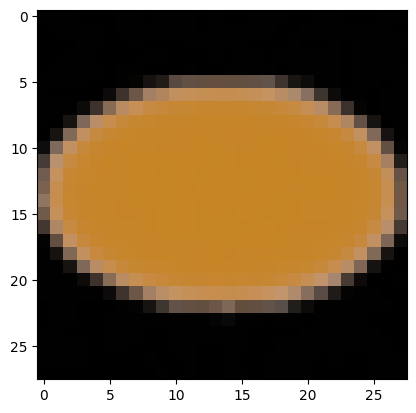

In [7]:
# VISUALIZE DATASET
import matplotlib.pyplot as plt
torch.manual_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)
configs = ["000","001","100","010"]
tf = transforms.Compose([transforms.Resize((args.pixel_size,args.pixel_size)), transforms.ToTensor()])
train_dataset = CLEVR_dataset(tf, args.num_samples, args.dataset, configs=["000","001","100","010"], training=True) 
img, label = train_dataset[0]

plt.imshow(img.permute(1, 2, 0))
label

# Training and Sampling Functions

In [8]:
def train_model(args):
    torch.manual_seed(args.seed)
    random.seed(args.seed)
    np.random.seed(args.seed)
    configs = ["000","001","100","010"]
    tf = transforms.Compose([transforms.Resize((args.pixel_size,args.pixel_size)), transforms.ToTensor()])
    model = DDPM(ContextUnet(3,args.n_feat,[2,3,1],args.type_attention), (args.lrate,0.02), args.n_T, device)
    model = model.to(device)
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=args.lrate)
    train_dataset = CLEVR_dataset(tf, args.num_samples, args.dataset, configs=["000","001","100","010"], training=True) 
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)
    for ep in tqdm(range(args.n_epoch), desc="Training Epochs"):
        model.train()
        losses = []

        # Wrapping loader with tqdm to track batch progress
        for x, c in tqdm(train_dataloader, desc=f"Epoch {ep+1}", leave=False):
            x = x.to(device)
            cl = [c[i].to(device) for i in c]
            # save first 10 images in x to debug using grid vu grid
            if ep==0 and len(losses)==0:
                grid = vutils.make_grid(x[:10], nrow=5, normalize=True)
                plt.imshow(grid.permute(1, 2, 0).cpu())
                plt.axis('off')
                plt.show()
            
            # TODO
            # 1. Zero gradients
            optim.zero_grad()

            # 2. Calculate loss
            loss = model(x, cl)
            
            # 3. Backpropagate
            loss.backward()
            
            # 4. Optimize
            optim.step()
            
            # 5. Log loss
            losses.append(loss.item())
            
            #raise NotImplementedError("Implement training loop logic inside each epoch")
            
        tqdm.write(f"Epoch {ep+1}/{args.n_epoch}, Loss: {np.mean(losses):.4f}")
        
        
    return model


In [9]:
def sample_images(model, args, config="000"):
    model.eval()
    tf = transforms.Compose([transforms.Resize((args.pixel_size,args.pixel_size)), transforms.ToTensor()])
    test_dataset = CLEVR_dataset(
        tf, args.n_sample,
        args.dataset,
        configs=config,
        training=False,
        test_size=args.test_size,
        )
    test_loader = DataLoader(test_dataset,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=0)
    x_real, c_gen = next(iter(test_loader))
    cl = {k: v[:args.n_sample].to(device) for k, v in c_gen.items()}
    gen = model.sample(args.n_sample, cl, (3,args.pixel_size,args.pixel_size))
    return gen


# Quantitative measure

 ## 🧠 MLP Probe for Context Prediction

 This section defines a simple **multi-head MLP classifier** used to evaluate whether generated images retain the correct **contextual information** (shape, color, size).

 ### 🧩 MLP Architecture
 - Takes a flattened image as input.
 - Outputs three predictions via separate linear heads:
   - `0`: shape (3 classes)
   - `1`: color (3 classes)
   - `2`: size (2 classes)

# ### 📊 Accuracy Evaluation
 The `calc_acc` function:
 - Passes generated images through the MLP probe.
 - Computes prediction accuracy for each context attribute.
 - Used to **quantitatively assess how well the model preserves conditioning** during generation.

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dims):
        super().__init__()

        self.output_fc0 = nn.Linear(input_dim, output_dims[0])
        self.output_fc1 = nn.Linear(input_dim, output_dims[1])
        self.output_fc2 = nn.Linear(input_dim, output_dims[2])

    def forward(self, x):
        batch_size = x.shape[0]
        x = x[:,:3,:,:].reshape(batch_size, -1)

        y_pred = {}
        y_pred[0] = self.output_fc0(x)
        y_pred[1] = self.output_fc1(x)
        y_pred[2] = self.output_fc2(x)

        return y_pred 


In [11]:
probe_input_dim = args.pixel_size * args.pixel_size * 3
classifier_linear = MLP(probe_input_dim, [3,3,2,2])
classifier_linear.load_state_dict(torch.load(f"{CV_PATH_DDPM}/probe.pt", map_location=torch.device(device)))
classifier_linear = classifier_linear.to(device)

In [12]:
def calc_acc(preds, obs, classifier, nclasses=3):
    y_pred = classifier(preds) #(torch.from_numpy(preds).to(device))
    accs = []
    preds = []
    for ii in range(nclasses): 
        top_pred = y_pred[ii].argmax(1, keepdim=True).detach().cpu().numpy()
        acc = np.array(top_pred[:,0]==int(obs[ii]), dtype=np.int64) 
        accs.append( acc ) 
        preds.append( top_pred[:,0] ) 
    return np.array(preds), np.array(accs)


# Run Training or Sampling

losses should be decreasing and going below 0.2 after 1 epoch and below 0.005 after 50 epochs

Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

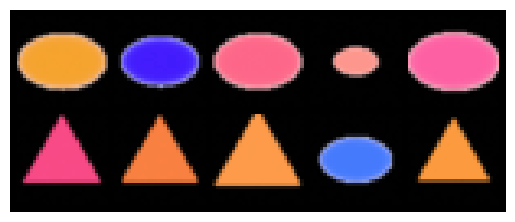


Training Epochs:   1%|          | 1/100 [05:51<9:40:00, 351.52s/it]

Epoch 1/100, Loss: 0.1731



Training Epochs:   2%|▏         | 2/100 [11:33<9:24:38, 345.70s/it]

Epoch 2/100, Loss: 0.0557



Training Epochs:   3%|▎         | 3/100 [17:11<9:13:05, 342.12s/it]

Epoch 3/100, Loss: 0.0342



Training Epochs:   4%|▍         | 4/100 [22:50<9:05:27, 340.91s/it]

Epoch 4/100, Loss: 0.0287



Training Epochs:   5%|▌         | 5/100 [28:20<8:53:38, 337.04s/it]

Epoch 5/100, Loss: 0.0261



Training Epochs:   6%|▌         | 6/100 [33:50<8:44:26, 334.75s/it]

Epoch 6/100, Loss: 0.0226



Training Epochs:   7%|▋         | 7/100 [39:24<8:38:34, 334.56s/it]

Epoch 7/100, Loss: 0.0181



Training Epochs:   8%|▊         | 8/100 [44:54<8:30:42, 333.07s/it]

Epoch 8/100, Loss: 0.0152



Training Epochs:   9%|▉         | 9/100 [50:25<8:23:55, 332.26s/it]

Epoch 9/100, Loss: 0.0154



Training Epochs:  10%|█         | 10/100 [55:57<8:18:38, 332.43s/it]

Epoch 10/100, Loss: 0.0147



Training Epochs:  11%|█         | 11/100 [1:01:36<8:16:06, 334.45s/it]

Epoch 11/100, Loss: 0.0130



Training Epochs:  12%|█▏        | 12/100 [1:07:06<8:08:31, 333.08s/it]

Epoch 12/100, Loss: 0.0128



Training Epochs:  13%|█▎        | 13/100 [1:12:37<8:01:49, 332.29s/it]

Epoch 13/100, Loss: 0.0121



Training Epochs:  14%|█▍        | 14/100 [1:18:07<7:55:13, 331.55s/it]

Epoch 14/100, Loss: 0.0116



Training Epochs:  15%|█▌        | 15/100 [1:23:37<7:49:10, 331.18s/it]

Epoch 15/100, Loss: 0.0124



Training Epochs:  16%|█▌        | 16/100 [1:29:07<7:43:01, 330.74s/it]

Epoch 16/100, Loss: 0.0100



Training Epochs:  17%|█▋        | 17/100 [1:34:37<7:37:08, 330.46s/it]

Epoch 17/100, Loss: 0.0107



Training Epochs:  18%|█▊        | 18/100 [1:40:07<7:31:26, 330.32s/it]

Epoch 18/100, Loss: 0.0093



Training Epochs:  19%|█▉        | 19/100 [1:45:36<7:25:43, 330.17s/it]

Epoch 19/100, Loss: 0.0098



Training Epochs:  20%|██        | 20/100 [1:51:07<7:20:16, 330.21s/it]

Epoch 20/100, Loss: 0.0113



Training Epochs:  21%|██        | 21/100 [1:56:36<7:14:30, 330.01s/it]

Epoch 21/100, Loss: 0.0099



Training Epochs:  22%|██▏       | 22/100 [2:02:06<7:09:06, 330.09s/it]

Epoch 22/100, Loss: 0.0105



Training Epochs:  23%|██▎       | 23/100 [2:07:37<7:03:45, 330.20s/it]

Epoch 23/100, Loss: 0.0089



Training Epochs:  24%|██▍       | 24/100 [2:13:07<6:58:05, 330.07s/it]

Epoch 24/100, Loss: 0.0089



Training Epochs:  25%|██▌       | 25/100 [2:18:36<6:52:22, 329.90s/it]

Epoch 25/100, Loss: 0.0084



Training Epochs:  26%|██▌       | 26/100 [2:24:06<6:46:57, 329.97s/it]

Epoch 26/100, Loss: 0.0072



Training Epochs:  27%|██▋       | 27/100 [2:29:36<6:41:27, 329.97s/it]

Epoch 27/100, Loss: 0.0080



Training Epochs:  28%|██▊       | 28/100 [2:35:06<6:35:51, 329.89s/it]

Epoch 28/100, Loss: 0.0082



Training Epochs:  29%|██▉       | 29/100 [2:40:36<6:30:19, 329.86s/it]

Epoch 29/100, Loss: 0.0074



Training Epochs:  30%|███       | 30/100 [2:46:05<6:24:44, 329.78s/it]

Epoch 30/100, Loss: 0.0100



Training Epochs:  31%|███       | 31/100 [2:51:35<6:19:08, 329.69s/it]

Epoch 31/100, Loss: 0.0077



Training Epochs:  32%|███▏      | 32/100 [2:57:05<6:13:47, 329.81s/it]

Epoch 32/100, Loss: 0.0069



Training Epochs:  33%|███▎      | 33/100 [3:02:35<6:08:24, 329.92s/it]

Epoch 33/100, Loss: 0.0077



Training Epochs:  34%|███▍      | 34/100 [3:08:05<6:02:54, 329.91s/it]

Epoch 34/100, Loss: 0.0076



Training Epochs:  35%|███▌      | 35/100 [3:13:34<5:57:14, 329.77s/it]

Epoch 35/100, Loss: 0.0068



Training Epochs:  36%|███▌      | 36/100 [3:19:05<5:51:51, 329.86s/it]

Epoch 36/100, Loss: 0.0066



Training Epochs:  37%|███▋      | 37/100 [3:24:35<5:46:30, 330.01s/it]

Epoch 37/100, Loss: 0.0074



Training Epochs:  38%|███▊      | 38/100 [3:30:05<5:41:00, 330.01s/it]

Epoch 38/100, Loss: 0.0064



Training Epochs:  39%|███▉      | 39/100 [3:35:35<5:35:30, 330.01s/it]

Epoch 39/100, Loss: 0.0055



Training Epochs:  40%|████      | 40/100 [3:41:05<5:29:53, 329.90s/it]

Epoch 40/100, Loss: 0.0075



Training Epochs:  41%|████      | 41/100 [3:46:34<5:24:19, 329.82s/it]

Epoch 41/100, Loss: 0.0056



Training Epochs:  42%|████▏     | 42/100 [3:52:04<5:18:49, 329.81s/it]

Epoch 42/100, Loss: 0.0072



Training Epochs:  43%|████▎     | 43/100 [3:57:34<5:13:27, 329.96s/it]

Epoch 43/100, Loss: 0.0053



Training Epochs:  44%|████▍     | 44/100 [4:03:05<5:08:10, 330.18s/it]

Epoch 44/100, Loss: 0.0065



Training Epochs:  45%|████▌     | 45/100 [4:08:35<5:02:39, 330.17s/it]

Epoch 45/100, Loss: 0.0070



Training Epochs:  46%|████▌     | 46/100 [4:14:04<4:56:49, 329.80s/it]

Epoch 46/100, Loss: 0.0059



Training Epochs:  47%|████▋     | 47/100 [4:19:33<4:51:08, 329.59s/it]

Epoch 47/100, Loss: 0.0054



Training Epochs:  48%|████▊     | 48/100 [4:25:04<4:45:53, 329.88s/it]

Epoch 48/100, Loss: 0.0052



Training Epochs:  49%|████▉     | 49/100 [4:30:35<4:40:38, 330.16s/it]

Epoch 49/100, Loss: 0.0051



Training Epochs:  50%|█████     | 50/100 [4:36:04<4:34:58, 329.98s/it]

Epoch 50/100, Loss: 0.0056



Training Epochs:  51%|█████     | 51/100 [4:41:34<4:29:30, 330.02s/it]

Epoch 51/100, Loss: 0.0067



Training Epochs:  52%|█████▏    | 52/100 [4:47:04<4:23:59, 329.99s/it]

Epoch 52/100, Loss: 0.0057



Training Epochs:  53%|█████▎    | 53/100 [4:52:35<4:18:38, 330.19s/it]

Epoch 53/100, Loss: 0.0104



Training Epochs:  54%|█████▍    | 54/100 [4:58:06<4:13:19, 330.43s/it]

Epoch 54/100, Loss: 0.0059



Training Epochs:  55%|█████▌    | 55/100 [5:03:37<4:07:59, 330.65s/it]

Epoch 55/100, Loss: 0.0053



Training Epochs:  56%|█████▌    | 56/100 [5:09:07<4:02:24, 330.56s/it]

Epoch 56/100, Loss: 0.0061



Training Epochs:  57%|█████▋    | 57/100 [5:14:38<3:56:51, 330.50s/it]

Epoch 57/100, Loss: 0.0059



Training Epochs:  58%|█████▊    | 58/100 [5:20:08<3:51:15, 330.38s/it]

Epoch 58/100, Loss: 0.0057



Training Epochs:  59%|█████▉    | 59/100 [5:25:39<3:45:56, 330.66s/it]

Epoch 59/100, Loss: 0.0057



Training Epochs:  60%|██████    | 60/100 [5:31:12<3:40:59, 331.50s/it]

Epoch 60/100, Loss: 0.0047



Training Epochs:  61%|██████    | 61/100 [5:36:42<3:35:06, 330.94s/it]

Epoch 61/100, Loss: 0.0059



Training Epochs:  62%|██████▏   | 62/100 [5:42:12<3:29:22, 330.58s/it]

Epoch 62/100, Loss: 0.0054



Training Epochs:  63%|██████▎   | 63/100 [5:47:41<3:23:37, 330.20s/it]

Epoch 63/100, Loss: 0.0051



Training Epochs:  64%|██████▍   | 64/100 [5:53:11<3:18:00, 330.00s/it]

Epoch 64/100, Loss: 0.0057



Training Epochs:  65%|██████▌   | 65/100 [5:58:42<3:12:38, 330.25s/it]

Epoch 65/100, Loss: 0.0048



Training Epochs:  66%|██████▌   | 66/100 [6:04:12<3:07:14, 330.41s/it]

Epoch 66/100, Loss: 0.0053



Training Epochs:  67%|██████▋   | 67/100 [6:09:41<3:01:30, 330.00s/it]

Epoch 67/100, Loss: 0.0056



Training Epochs:  68%|██████▊   | 68/100 [6:15:23<2:57:48, 333.40s/it]

Epoch 68/100, Loss: 0.0048



Training Epochs:  69%|██████▉   | 69/100 [6:20:54<2:51:54, 332.71s/it]

Epoch 69/100, Loss: 0.0043



Training Epochs:  70%|███████   | 70/100 [6:26:25<2:46:04, 332.14s/it]

Epoch 70/100, Loss: 0.0047



Training Epochs:  71%|███████   | 71/100 [6:31:55<2:40:14, 331.54s/it]

Epoch 71/100, Loss: 0.0043



Training Epochs:  72%|███████▏  | 72/100 [6:37:25<2:34:31, 331.13s/it]

Epoch 72/100, Loss: 0.0044



Training Epochs:  73%|███████▎  | 73/100 [6:42:55<2:28:53, 330.87s/it]

Epoch 73/100, Loss: 0.0048



Training Epochs:  74%|███████▍  | 74/100 [6:48:25<2:23:17, 330.66s/it]

Epoch 74/100, Loss: 0.0048



Training Epochs:  75%|███████▌  | 75/100 [6:53:56<2:17:45, 330.62s/it]

Epoch 75/100, Loss: 0.0069



Training Epochs:  76%|███████▌  | 76/100 [6:59:26<2:12:14, 330.60s/it]

Epoch 76/100, Loss: 0.0051



Training Epochs:  77%|███████▋  | 77/100 [7:04:57<2:06:41, 330.50s/it]

Epoch 77/100, Loss: 0.0049



Training Epochs:  78%|███████▊  | 78/100 [7:10:27<2:01:12, 330.58s/it]

Epoch 78/100, Loss: 0.0056



Training Epochs:  79%|███████▉  | 79/100 [7:15:57<1:55:36, 330.29s/it]

Epoch 79/100, Loss: 0.0038



Training Epochs:  80%|████████  | 80/100 [7:21:27<1:50:04, 330.20s/it]

Epoch 80/100, Loss: 0.0056



Training Epochs:  81%|████████  | 81/100 [7:26:58<1:44:39, 330.51s/it]

Epoch 81/100, Loss: 0.0040



Training Epochs:  82%|████████▏ | 82/100 [7:32:29<1:39:09, 330.54s/it]

Epoch 82/100, Loss: 0.0036



Training Epochs:  83%|████████▎ | 83/100 [7:37:59<1:33:38, 330.50s/it]

Epoch 83/100, Loss: 0.0041



Training Epochs:  84%|████████▍ | 84/100 [7:43:30<1:28:08, 330.52s/it]

Epoch 84/100, Loss: 0.0036



Training Epochs:  85%|████████▌ | 85/100 [7:49:01<1:22:39, 330.61s/it]

Epoch 85/100, Loss: 0.0042



Training Epochs:  86%|████████▌ | 86/100 [7:54:32<1:17:10, 330.77s/it]

Epoch 86/100, Loss: 0.0046



Training Epochs:  87%|████████▋ | 87/100 [8:00:04<1:11:43, 331.04s/it]

Epoch 87/100, Loss: 0.0044



Training Epochs:  88%|████████▊ | 88/100 [8:05:34<1:06:09, 330.81s/it]

Epoch 88/100, Loss: 0.0039



Training Epochs:  89%|████████▉ | 89/100 [8:11:04<1:00:38, 330.73s/it]

Epoch 89/100, Loss: 0.0045



Training Epochs:  90%|█████████ | 90/100 [8:16:35<55:06, 330.62s/it]  

Epoch 90/100, Loss: 0.0061



Training Epochs:  91%|█████████ | 91/100 [8:22:06<49:36, 330.73s/it]

Epoch 91/100, Loss: 0.0055



Training Epochs:  92%|█████████▏| 92/100 [8:27:36<44:05, 330.64s/it]

Epoch 92/100, Loss: 0.0050



Training Epochs:  93%|█████████▎| 93/100 [8:33:07<38:33, 330.56s/it]

Epoch 93/100, Loss: 0.0040



Training Epochs:  94%|█████████▍| 94/100 [8:38:37<33:03, 330.59s/it]

Epoch 94/100, Loss: 0.0042



Training Epochs:  95%|█████████▌| 95/100 [8:44:08<27:32, 330.60s/it]

Epoch 95/100, Loss: 0.0046



Training Epochs:  96%|█████████▌| 96/100 [8:49:38<22:02, 330.56s/it]

Epoch 96/100, Loss: 0.0055



Training Epochs:  97%|█████████▋| 97/100 [8:55:09<16:31, 330.63s/it]

Epoch 97/100, Loss: 0.0041



Training Epochs:  98%|█████████▊| 98/100 [9:00:40<11:01, 330.83s/it]

Epoch 98/100, Loss: 0.0036



Training Epochs:  99%|█████████▉| 99/100 [9:06:11<05:30, 330.82s/it]

Epoch 99/100, Loss: 0.0049



Training Epochs: 100%|██████████| 100/100 [9:11:42<00:00, 331.02s/it]

Epoch 100/100, Loss: 0.0048


In [57]:
model = train_model(args) 

In [ ]:
torch.save(model.state_dict(), args.save_model_path)
print(f"Model saved to {args.save_model_path}")

# Sampling, Evaluation and Visualization

loading the model that was trained before 

In [13]:
n_classes = [2, 3, 1]

# Build model
ddpm = DDPM(
    ContextUnet(
        in_channels=3,
        n_feat=args.n_feat,
        n_classes=n_classes,
        type_attention=args.type_attention
    ),
    betas=(args.lrate, 0.02),
    n_T=args.n_T,
    device=device,
).to(device)
ddpm.eval()
# Load weights

state = torch.load(args.save_model_path, map_location=device)
ddpm.load_state_dict(state)
ddpm = ddpm.to(device)
print(f"Loaded model from {args.save_model_path}")

Loaded model from comp_model.pth


Accuracy for config 000: 1.0


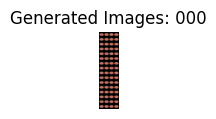

Generated images for config 000 saved as generated_images_000.png


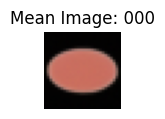

Mean image for config 000 saved as mean_image_000.png
Accuracy for config 001: 1.0


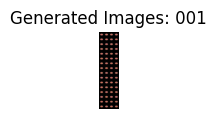

Generated images for config 001 saved as generated_images_001.png


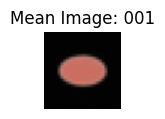

Mean image for config 001 saved as mean_image_001.png
Accuracy for config 100: 1.0


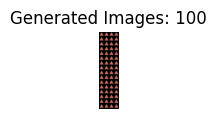

Generated images for config 100 saved as generated_images_100.png


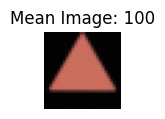

Mean image for config 100 saved as mean_image_100.png
Accuracy for config 010: 1.0


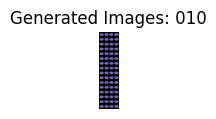

Generated images for config 010 saved as generated_images_010.png


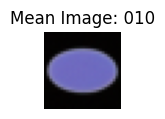

Mean image for config 010 saved as mean_image_010.png


In [14]:
#sample images from all configs
#create subplots for each config
import torchvision.utils as vutils
nrows = 4
ncols = 1

acc = {}
sample_train_sources = ["000","001","100","010"] # configurations to sample from that was seen during the training
for config in sample_train_sources:
       # Plot the generated images

   gen = sample_images(ddpm, args, config)
   #clip gen to 0-1
   gen = torch.clamp(gen, 0, 1)

   # calc acc
   preds, accs = calc_acc(gen, config, classifier_linear, nclasses=3)
   acc[config] = accs.mean()
   print(f"Accuracy for config {config}: {acc[config]}")

   grid = vutils.make_grid(gen.cpu(), nrow=nrows, normalize=False)

   plt.figure(figsize=(nrows, ncols))
   plt.axis("off")
   plt.title(f"Generated Images: {config}")
   plt.imshow(grid.permute(1, 2, 0))  # CxHxW -> HxWxC
   plt.show()
   vutils.save_image(gen.cpu(), f"generated_images_{config}.png", nrow=nrows, normalize=False)
   print(f"Generated images for config {config} saved as generated_images_{config}.png")

   #now save mean image
   mean_image = gen.mean(dim=0)        
   mean_image = torch.clamp(mean_image, 0, 1)
   grid = vutils.make_grid(mean_image.cpu(), nrow=nrows, normalize=False)
   plt.figure(figsize=(nrows, ncols))
   plt.axis("off")
   plt.title(f"Mean Image: {config}")
   plt.imshow(grid.permute(1, 2, 0))  # CxHxW -> HxWxC
   plt.show()
   vutils.save_image(mean_image.cpu(), f"mean_image_{config}.png", nrow=nrows, normalize=False)
   print(f"Mean image for config {config} saved as mean_image_{config}.png")


 ## 🔍 Generalization: Sampling from Unseen Contexts

 So far, we’ve only sampled from **training configurations** like `000`, `001`, etc.
 But what happens when we ask the model to generate from **unseen combinations** of shape, color, and size?

 > 🤔 **Big Question:**  
 > Can a diffusion model generalize to novel combinations of known attributes it has never seen together during training?

# In this next cell, you will:
 - Define a set of **unseen context configurations**
 - Generate images from the model using those contexts
 - Evaluate and **visually inspect** if the model understands the disentangled structure of the conditioning
 - Check the **accuracy** of the generated images using the MLP probe
 ✍️ Try it yourself below!



Accuracy for config 011: 1.0


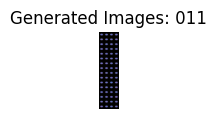

unseen Generated images for config 011 saved as enseen_generated_images_011.png


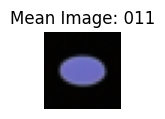

unseen Mean image for config 011 saved as unseen_mean_image_011.png
Accuracy for config 110: 1.0


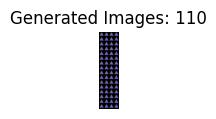

unseen Generated images for config 110 saved as enseen_generated_images_110.png


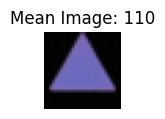

unseen Mean image for config 110 saved as unseen_mean_image_110.png
Accuracy for config 101: 1.0


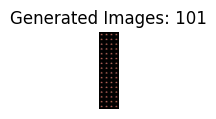

unseen Generated images for config 101 saved as enseen_generated_images_101.png


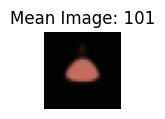

unseen Mean image for config 101 saved as unseen_mean_image_101.png
Accuracy for config 111: 1.0


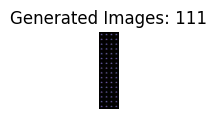

unseen Generated images for config 111 saved as enseen_generated_images_111.png


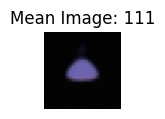

unseen Mean image for config 111 saved as unseen_mean_image_111.png


In [15]:
#sample images from all configs
#create subplots for each config
import torchvision.utils as vutils
nrows = 4
ncols = 1

acc = {}
sample_train_sources = ["011", "110", "101", "111"] #unseen data
for config in sample_train_sources:
       # Plot the generated images

   gen = sample_images(ddpm, args, config)
   #clip gen to 0-1
   gen = torch.clamp(gen, 0, 1)

   # calc acc
   preds, accs = calc_acc(gen, config, classifier_linear, nclasses=3)
   acc[config] = accs.mean()
   print(f"Accuracy for config {config}: {acc[config]}")

   grid = vutils.make_grid(gen.cpu(), nrow=nrows, normalize=False)

   plt.figure(figsize=(nrows, ncols))
   plt.axis("off")
   plt.title(f"Generated Images: {config}")
   plt.imshow(grid.permute(1, 2, 0))  # CxHxW -> HxWxC
   plt.show()
   vutils.save_image(gen.cpu(), f"unseen_generated_images_{config}.png", nrow=nrows, normalize=False)
   print(f"unseen Generated images for config {config} saved as enseen_generated_images_{config}.png")

   #now save mean image
   mean_image = gen.mean(dim=0)        
   mean_image = torch.clamp(mean_image, 0, 1)
   grid = vutils.make_grid(mean_image.cpu(), nrow=nrows, normalize=False)
   plt.figure(figsize=(nrows, ncols))
   plt.axis("off")
   plt.title(f"Mean Image: {config}")
   plt.imshow(grid.permute(1, 2, 0))  # CxHxW -> HxWxC
   plt.show()
   vutils.save_image(mean_image.cpu(), f"unseen_mean_image_{config}.png", nrow=nrows, normalize=False)
   print(f"unseen Mean image for config {config} saved as unseen_mean_image_{config}.png")


# For more fun experiments try different configurations like adding Attention layers, changing the number of diffusion steps, or using different datasets.